In [2]:
# Standard Libraries
from collections import Counter
from itertools import product
import os
from os import listdir, path

# Third-Party Libraries
from matplotlib import patheffects
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch, Rectangle
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import joblib 

pd.options.display.max_columns = 500
import warnings
warnings.filterwarnings("ignore")

input_path = 'data'

class Imputer:
    def __init__(self, target, cols, preprocessor, model, _range,n=-1):
        self.target = target
        self.cols = cols
        self.preprocessor = preprocessor
        self.model = model
        self.range = _range
        self.n=n
        
    def transform(self, df):
        if self.target not in df:
            df[self.target] = np.nan
        df_null = df[df[self.target].isnull()]
        missing = set(self.cols)-set(df_null.columns)
        for col in missing:
            df_null[col] = np.nan
        dfx = df_null[self.cols]        
        if not dfx.empty:
            if self.preprocessor is not None:
                X = self.preprocessor.transform(dfx)
            else:
                X = dfx
            predicted_values = self.model.predict(X)
            np.clip(predicted_values, self.range[0], self.range[1], out=predicted_values)
            df.loc[df[self.target].isnull(), self.target] = predicted_values
        return df
    

def parse_kinetic(x):        
    if x in com_map:
        return com_map[x]
    prefix = x.split('_')[0]
    if prefix == 'AVG':        
        marker = x.split('_')[1]
        marker = markername_map[marker].replace('estimated','est.')
        return '%s\n[mean up to day X]'%(marker)
    
    prefix,marker,suffix = x.split('_')    
    marker = markername_map[marker].replace('estimated','est.')    
    if prefix == 'NA':
        op = '[REQ. D%s]'%suffix
    if prefix == 'lab':
        op = '[D%s]'%suffix
    if prefix =='delta':
        op = '[D%s-D0]'%suffix
    if prefix == 'kindiff':
        op = '[D%s-D%s]'%(suffix[0],suffix[2])
    if prefix =='deltaratio':
        #op = '[D%s/D0]'%suffix
        op = '[ratio D%s to D0]'%suffix
    if prefix == 'kinratio':
        # op = '[D%s/D%s]'%(suffix[0],suffix[2])
        op = '[ratio D%s to D%s]'%(suffix[0],suffix[2])
    if prefix =='deltaabs':
        op = 'abs(D%s-D0)'%suffix
    if prefix == 'kinabs':
        op = 'abs(D%s-D%s)'%(suffix[0],suffix[2])
    if prefix =='deltasign':
        op = 'sign(D%s-D0)'%suffix
    if prefix == 'kinsign':
        op = 'sign(D%s-D%s)'%(suffix[0],suffix[2])
    return '%s\n%s'%(marker,op)

acr = pd.read_excel(path.join(input_path,'marker_translations.xlsx'))
marker_map = {}
for x in acr[['German Acronym','English Acronym']].itertuples():
    marker_map[x._1] = x._2    
markername_map = {}
for x in acr[['German Acronym','Description in English']].itertuples():
    markername_map[x._1] = x._2    
    
com_map = {
    'com_charlson_MyocardialInfarction': 'myocardial infarction',
    'com_charlson_CongestiveHeartFailure': 'congestive heart failure',
    'com_charlson_PeripheralVascularDisease': 'peripheral vascular disease',
    'com_charlson_CerebrovascularDisease': 'cerebrovascular disease',
    'com_charlson_Dementia': 'dementia',
    'com_charlson_ChronicPulmonaryDisease': 'chronic pulmonary disease',
    'com_charlson_ConnectiveTissueDiseaseRheumaticDisease': 'rheumatic disease',
    'com_charlson_PepticUlcerDisease': 'peptic ulcer disease',
    'com_charlson_MildLiverDisease': 'mild liver disease',
    'com_charlson_ParaplegiaHemiplegia': 'paraplegia/hemiplegia',
    'com_charlson_RenalDisease': 'moderate/severe liver disease',
    'com_charlson_Cancer': 'cancer',
    'com_charlson_MetastaticCarcinoma': 'metastatic carcinoma',
    'com_charlson_HIV': 'HIV',
    'com_elix_CardiacArrhythmia': 'cardiac arrhythmia',
    'com_elix_ValvularDisease': 'valvular disease',
    'com_elix_PulmonaryCirculationDisorders': 'pulmonary circulation disorders',
    'com_elix_HypertensionUncomplicated': 'hypertension uncomplicated',
    'com_elix_HypertensionComplicated': 'hypertension complicated',
    'com_elix_OtherNeurologicalDisorders': 'other neurological disorders',
    'com_elix_Hypothyroidism': 'hypothyroidism',
    'com_elix_LiverDisease': 'liver disease',
    'com_elix_Lymphoma': 'lymphoma',
    'com_elix_SolidTumorNoMetastasis': 'solid tumor no metastasis',
    'com_elix_RheumatoidArthritis': 'rheumatoid arthritis',
    'com_elix_Coagulopathy': 'coagulopathy',
    'com_elix_WeightLoss': 'weight loss',
    'com_elix_FluidEcletrolyteDisorders': 'fluid electrolyte disorders',
    'com_elix_DeficiencyAnemia': 'deficiency anemia',
    'com_elix_AlcoholAbuse': 'alcohol abuse',
    'com_elix_DrugAbuse': 'drug abuse',
    'com_elix_Psychoses': 'psychoses',
    'com_elix_Depression': 'depression',
    'age':'age',
    'sex':'sex',
    'asa':'ASA score',
    'emergencysurgery':'emergency op',
    'atb_preop':'antibiotics preOp',
    'imcib':'moved to ICU',
    'night_surg':'night Op',
    'duration_of_surg':'op duration (min)',
    'vascular': 'vascular',
    'visceral': 'visceral',
    'ORL':'ENT',
    'gynecology': 'gynaecology',
    'neuro':'neurosurgery',
    'ophthalmology': 'ophthalmology',
    'ortho': 'orthopaedic/trauma',
    'pediatric': 'paediatric',
    'plastic_hand': 'plastic/hand',
    'thoracic': 'thoracic',
    'urology':'urology',
    'dermatology': 'dermatology'
}

def sign_custom(x):
    return 1 if x>=0 else -1
epsilon_delta = 0.00001
epsilon_beta = 0.00001

def compute_kinetic_features(dd,marker,max_day):
    ctemp = 'lab_%s_%d'
    bl = ctemp%(marker,0) #baseline
    for i in range(1,max_day+1):        
        ### NEW: FORBIDDEN LIST IMPUTATION
        if (marker,0) in forbidden_imputation or (marker,i) in forbidden_imputation:
            continue        
        a = ctemp%(marker,i)
        delta = dd[a]-dd[bl]
        delta_abs = np.abs(delta)
        delta_sign = delta.apply(sign_custom)
        deltap = delta.apply(lambda x:x if np.abs(x)>epsilon_delta else sign_custom(x)*epsilon_delta)
        blp = dd[bl].apply(lambda x:x if np.abs(x)>epsilon_delta else sign_custom(x)*epsilon_delta)
        delta_ratio = deltap/blp
        dd['delta_%s_%d'%(marker,i)] = delta
        dd['deltaabs_%s_%d'%(marker,i)] = delta_abs
        dd['deltasign_%s_%d'%(marker,i)] = delta_sign
        dd['deltaratio_%s_%d'%(marker,i)] = delta_ratio
    if max_day<2:
        return dd
    for i in range(2,max_day+1):
        for j in range(1,i):
            if (marker,i) in forbidden_imputation or (marker,j) in forbidden_imputation:
                continue
            u = ctemp%(marker,i)
            v = ctemp%(marker,j)            
            delta = dd[v]-dd[u]
            delta_abs = np.abs(delta)
            delta_sign = delta.apply(sign_custom)
            deltap = delta.apply(lambda x:x if np.abs(x)>epsilon_delta else sign_custom(x)*epsilon_delta)
            blp = dd[u].apply(lambda x:x if np.abs(x)>epsilon_delta else sign_custom(x)*epsilon_delta)
            delta_ratio = deltap/blp
            dd['kindiff_%s_%d|%d'%(marker,i,j)] = delta
            dd['kinabs_%s_%d|%d'%(marker,i,j)] = delta_abs
            dd['kinsign_%s_%d|%d'%(marker,i,j)] = delta_sign
            dd['kinratio_%s_%d|%d'%(marker,i,j)] = delta_ratio
    return dd

### LOAD REQUIRED VARIABLES


### LOAD DATA FOR IMPUTATION 

day_X = 7 #Cohort from the study
day_Y = 2 #Day of prediction

clf = joblib.load(path.join(input_path,'model.pkl'))
ft_labels = joblib.load(path.join(input_path,'feature_labels.pkl'))
y_scores = joblib.load(path.join(input_path,'y_scores.pkl'))
y_test = joblib.load(path.join(input_path,'y_test.pkl'))
impu = joblib.load(path.join(input_path,'imputers.pkl'))

comorbidity_file = path.join(input_path,'comorbidities.txt')
x = pd.read_csv(comorbidity_file,sep=';', comment='#')
x['set'] = x['set'].apply(eval)
COM_MAPPING = x.set_index('name').to_dict()['set']

selected_markers = {'Creatinin', 'CRP', 'Thrombozyten', 'Alkphos'}
forbidden_imputation = set([
    ('Alkphos',0),('Alkphos',1),        
    ('Thrombozyten',0),
])

### LOAD DATA FOR SHAP PLOT

df_features = pd.read_csv(path.join(input_path,'df_features.csv'))
def cap_outliers(series):
    if len(series.unique())==2:
        return series
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    min_non_outlier = series[series >= lower_bound].min()
    max_non_outlier = series[series <= upper_bound].max()

    series = np.where(series < lower_bound, min_non_outlier, series)
    series = np.where(series > upper_bound, max_non_outlier, series)
    return series
# Apply the function to each column in the DataFrame
df_capped = df_features.apply(cap_outliers)
feature_values_normalized = (df_capped - df_capped.min()) / (df_capped.max() - df_capped.min())
###spread values
feature_values_normalized = np.power(feature_values_normalized, .45)
feature_values_normalized = (feature_values_normalized - feature_values_normalized.min()) / (feature_values_normalized.max() - feature_values_normalized.min())
feature_ranges = {}
for c in df_capped.columns:
    feature_ranges[c] = (df_capped[c].min(),df_capped[c].max())
    
df_shap = pd.read_csv(path.join(input_path,'shap_data.csv'))
sorted_features = df_shap.abs().mean().sort_values(ascending=False).index
df_ranges = pd.read_csv('infra/feature_ranges.csv')
feature_ranges = df_ranges.set_index('feature')[['min','max']].apply(tuple,axis=1).to_dict()
SELECTED_VARIABLES = ['duration_of_surg','com_elix_WeightLoss',
                      'deltaratio_CRP_1','deltaratio_CRP_2',
                      'lab_Thrombozyten_1','lab_Thrombozyten_2',
                      'lab_Alkphos_2', 'AVG_Alkphos',
                      'lab_Creatinin_0','deltaabs_Creatinin_1', 
                     ]

### Write template file

In [3]:
template_csv = path.join(input_path,'template.csv')
cols = ['_id','diagnosis','age','sex','asa','atb_preop',
        'duration_of_surg', 'emergencysurgery', 'night_surg', 'imcib', 
        'lab_Alkphos_0', 'lab_Alkphos_1', 'lab_Alkphos_2', 
        'lab_CRP_0', 'lab_CRP_1', 'lab_CRP_2', 
        'lab_Creatinin_0', 'lab_Creatinin_1', 'lab_Creatinin_2', 
        'lab_Thrombozyten_0', 'lab_Thrombozyten_1', 'lab_Thrombozyten_2']
df = pd.DataFrame(columns=cols)
df.to_csv(template_csv,index=None)

---
---
---

# Load your patient data here

In [4]:
input_file = path.join(input_path,'sample.csv') ###Substitute with your filled template.csv
df = pd.read_csv(input_file)
df

,_id,diagnosis,age,sex,asa,atb_preop,duration_of_surg,emergencysurgery,night_surg,imcib,lab_Alkphos_0,lab_Alkphos_1,lab_Alkphos_2,lab_CRP_0,lab_CRP_1,lab_CRP_2,lab_Creatinin_0,lab_Creatinin_1,lab_Creatinin_2,lab_Thrombozyten_0,lab_Thrombozyten_1,lab_Thrombozyten_2
0,p1,"B96.2, D64.9, E44.0, E83.38, E83.4, E87.1, G25...",60,1,4,0,420,0,0,1,80,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p2,"C38.4, D62, E46, I10.00, N18.3, R41.0, Z85.2, ...",80,1,3,0,176,0,0,0,90,NaN,NaN,4,72.0,126.0,NaN,147.0,162.0,NaN,NaN,NaN


### Compute variables

In [5]:
### Compute comorbidities

sets = []
for x in df.itertuples():    
    a = x.diagnosis.replace(' ','').split(',')
    b = [x.split('.')[0] for x in a]
    s = set(a+b)
    sets.append(s)    
df['icd10']=sets
for k,v in COM_MAPPING.items():
    df[k] = df['icd10'].apply(lambda x:1 if len(x&v)>0 else 0)
df.drop(columns=['diagnosis','icd10'],inplace=True)

### Compute NA (requested) features

col_labs = [x for x in df.columns if x.startswith('lab_')]
col_labs
for c in col_labs:
    df[c.replace('lab_','NA_')] = df[c].apply(lambda x:0 if pd.isnull(x) else 1)
    
### Perform imputation and compute kinetic features

for marker in selected_markers:
    for day_Z in range(0,day_Y+1):
        if (marker,day_Z) in forbidden_imputation:
            continue
        imputer = impu[(marker,day_X,day_Y,day_Z)]
        df = imputer.transform(df)
    df = compute_kinetic_features(df,marker,day_Y)
    if day_Y>0:
        df['AVG_'+marker] = df[[x for x in df.columns if x.startswith('lab_'+marker)]].mean(axis=1)
dtest = df[ft_labels]

### Predict!

y_pred = clf.predict(dtest)
y_scores = clf.predict_proba(dtest)[:, 1]
R = pd.DataFrame([y_pred,y_scores]).T
R.columns = ['prediction_binary','prediction_prob']
pd.concat((df[['_id']], R),axis=1)

,_id,prediction_binary,prediction_prob
0,p1,1.0,0.78
1,p2,0.0,0.44


---
# Compute SHAP radar

In [6]:
df_data = pd.concat((df[['_id']], R,dtest),axis=1)
df_data

,_id,prediction_binary,prediction_prob,lab_Alkphos_2,lab_CRP_0,lab_CRP_1,lab_CRP_2,lab_Creatinin_0,lab_Creatinin_1,lab_Creatinin_2,lab_Thrombozyten_1,lab_Thrombozyten_2,age,sex,asa,com_charlson_MyocardialInfarction,com_charlson_CongestiveHeartFailure,com_charlson_PeripheralVascularDisease,com_charlson_CerebrovascularDisease,com_charlson_Dementia,com_charlson_ChronicPulmonaryDisease,com_charlson_ConnectiveTissueDiseaseRheumaticDisease,com_charlson_PepticUlcerDisease,com_charlson_MildLiverDisease,com_charlson_ParaplegiaHemiplegia,com_charlson_RenalDisease,com_charlson_Cancer,com_charlson_MetastaticCarcinoma,com_charlson_HIV,com_elix_CardiacArrhythmia,com_elix_ValvularDisease,com_elix_PulmonaryCirculationDisorders,com_elix_HypertensionUncomplicated,com_elix_HypertensionComplicated,com_elix_OtherNeurologicalDisorders,com_elix_Hypothyroidism,com_elix_LiverDisease,com_elix_Lymphoma,com_elix_SolidTumorNoMetastasis,com_elix_RheumatoidArthritis,com_elix_Coagulopathy,com_elix_WeightLoss,com_elix_FluidEcletrolyteDisorders,com_elix_DeficiencyAnemia,com_elix_AlcoholAbuse,com_elix_DrugAbuse,com_elix_Psychoses,com_elix_Depression,emergencysurgery,atb_preop,imcib,night_surg,duration_of_surg,delta_Creatinin_1,deltaabs_Creatinin_1,deltasign_Creatinin_1,deltaratio_Creatinin_1,delta_Creatinin_2,deltaabs_Creatinin_2,deltasign_Creatinin_2,deltaratio_Creatinin_2,kindiff_Creatinin_2|1,kinabs_Creatinin_2|1,kinsign_Creatinin_2|1,kinratio_Creatinin_2|1,AVG_Creatinin,delta_CRP_1,deltaabs_CRP_1,deltasign_CRP_1,deltaratio_CRP_1,delta_CRP_2,deltaabs_CRP_2,deltasign_CRP_2,deltaratio_CRP_2,kindiff_CRP_2|1,kinabs_CRP_2|1,kinsign_CRP_2|1,kinratio_CRP_2|1,AVG_CRP,kindiff_Thrombozyten_2|1,kinabs_Thrombozyten_2|1,kinsign_Thrombozyten_2|1,kinratio_Thrombozyten_2|1,AVG_Thrombozyten,AVG_Alkphos,NA_Alkphos_0,NA_Alkphos_1,NA_Alkphos_2,NA_CRP_0,NA_CRP_1,NA_CRP_2,NA_Creatinin_0,NA_Creatinin_1,NA_Creatinin_2,NA_Thrombozyten_0,NA_Thrombozyten_1,NA_Thrombozyten_2
0,p1,1.0,0.78,83.493158,0,70.471662,228.179952,98.522663,127.842822,140.625263,212.196944,172.380982,60,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,420,29.320159,29.320159,1,0.297598,42.102600,42.102600,1,0.427339,-12.782441,12.782441,-1,-0.090897,122.330249,70.471662,70.471662,1,7.047166e+06,228.179952,228.179952,1,2.281800e+07,-157.70829,157.70829,-1,-0.691158,99.550538,39.815962,39.815962,1,0.230977,192.288963,81.746579,1,0,0,1,0,0,0,0,0,0,0,0
1,p2,0.0,0.44,89.177942,4,72.000000,126.000000,147.538595,147.000000,162.000000,176.254762,162.237864,80,1,3,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,176,-0.538595,0.538595,-1,-0.003651,14.461405,14.461405,1,0.098018,-15.000000,15.000000,-1,-0.092593,152.179532,68.000000,68.000000,1,1.700000e+01,122.000000,122.000000,1,3.050000e+01,-54.00000,54.00000,-1,-0.428571,67.333333,14.016898,14.016898,1,0.086397,169.246313,89.588971,1,0,0,1,1,1,0,1,1,0,0,0


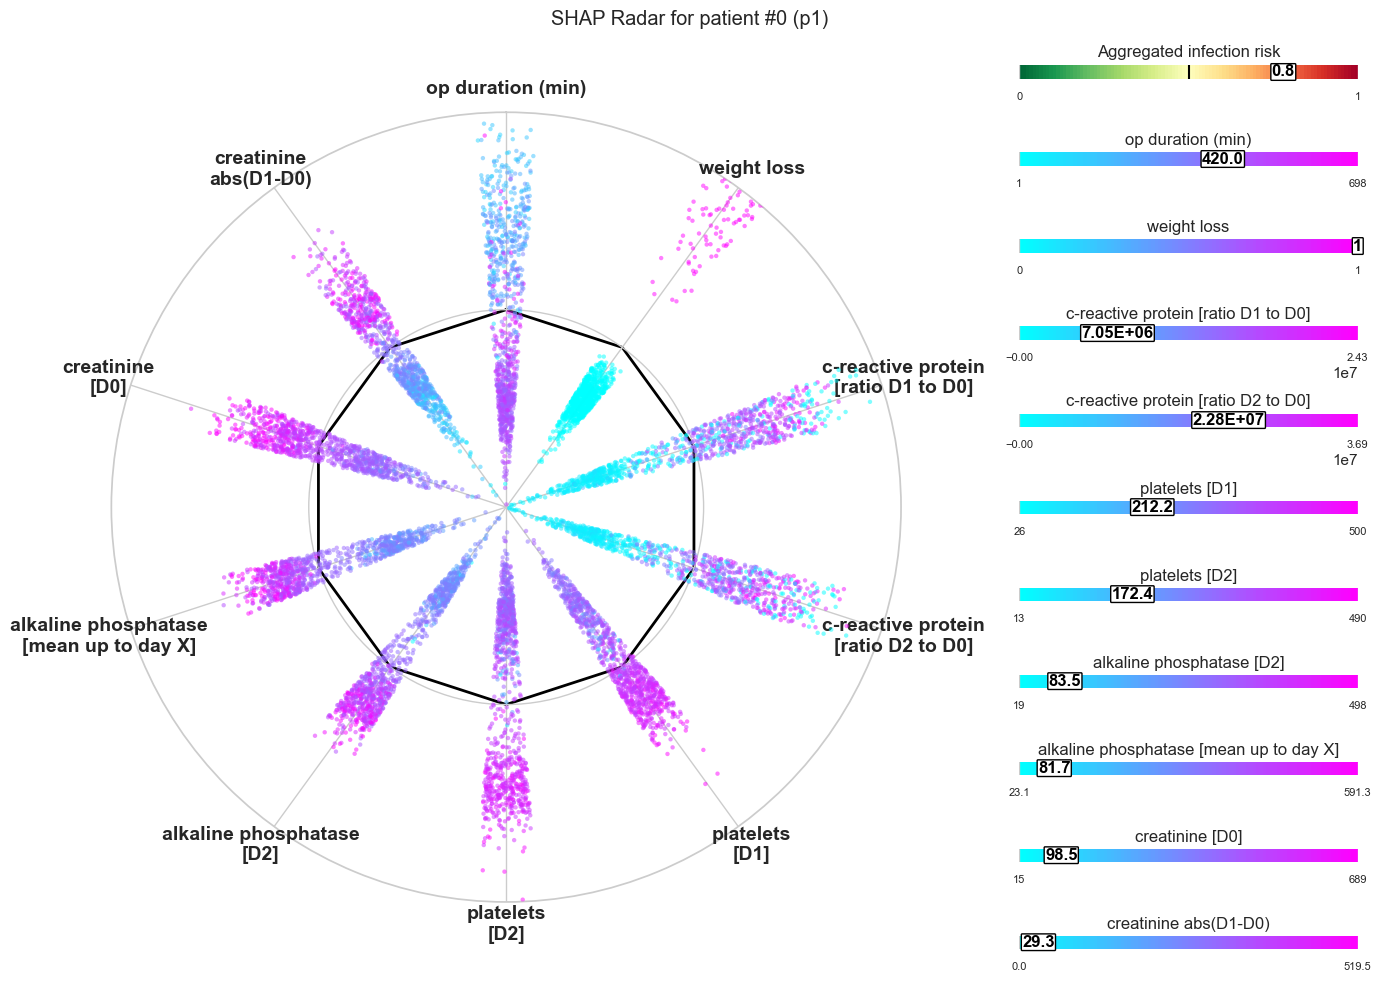

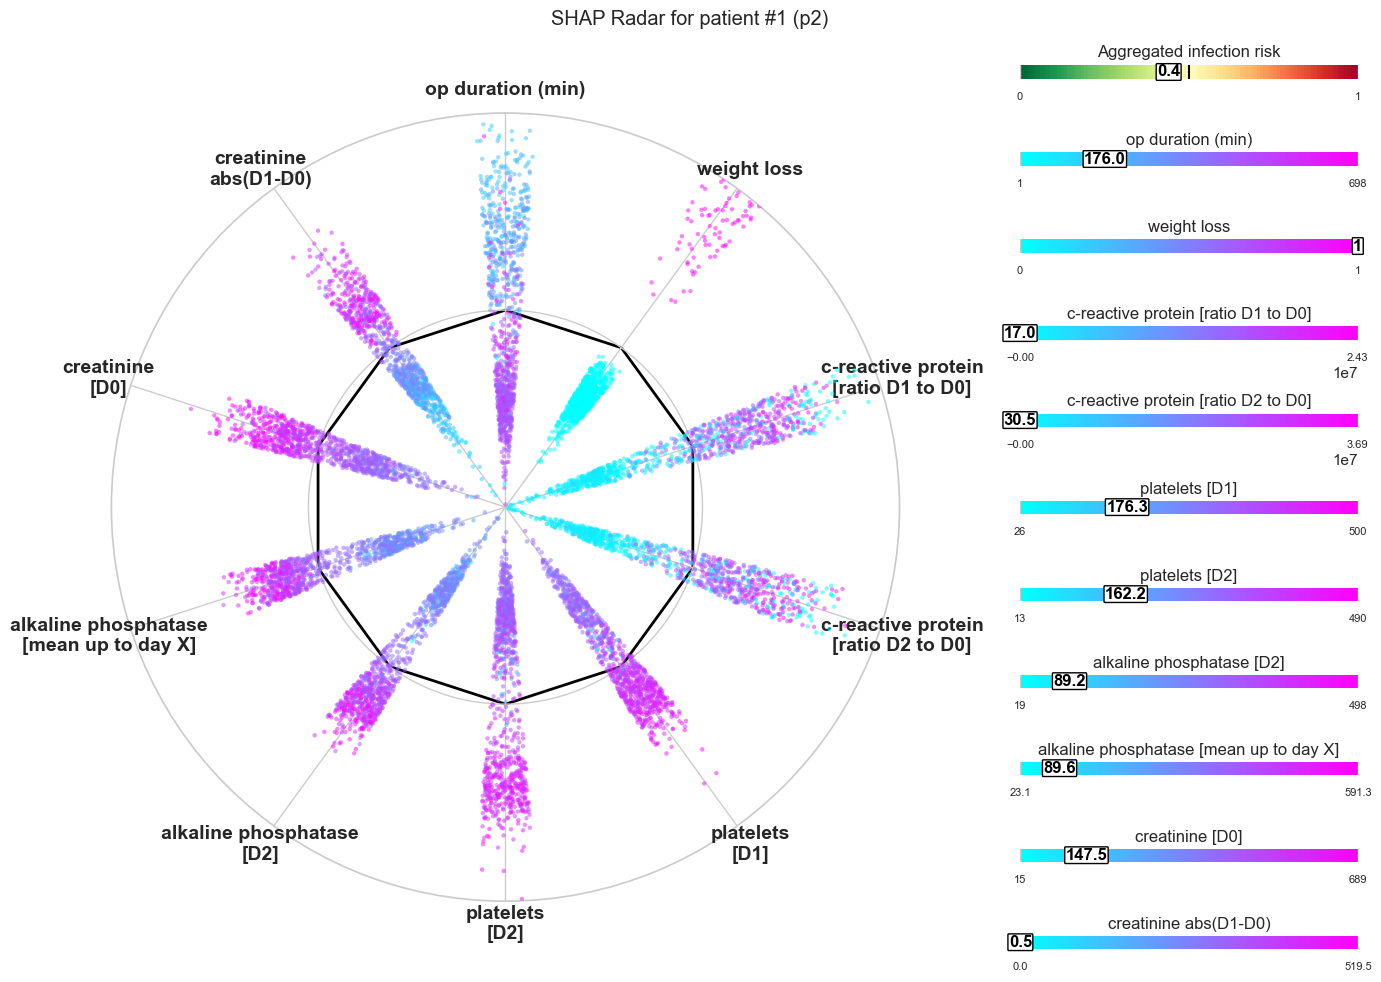

In [12]:
sns.set_style('whitegrid')
top_features = SELECTED_VARIABLES
_K = len(top_features)
jitter = 0.08


for ipat in range(len(df_data)):            
    new_data_point = df_data.iloc[ipat].to_dict()

    new_risk = new_data_point['prediction_prob']
    new_pred = new_data_point['prediction_binary']

    import string
    lower = list(string.ascii_lowercase)
    mosaic = '\n'.join(['X0']+['X%s'%lower[i] for i in range(len(top_features))])
    sns.set(style="whitegrid",rc={"axes.axisbelow": False})
    # sns.set(font_scale=1)
    fig, axes = plt.subplot_mosaic(mosaic,                               
                                   figsize=(14,10),
                                   width_ratios=[0.7,0.3],
                                   per_subplot_kw={"X": {"projection": "polar"}},)

    ################PLOT SPIDER
    ax = axes['X']
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2.0)
    # Compute angle for each axis
    theta = np.linspace(0,0+2 * np.pi, _K, endpoint=False)
    # Repeat the first value to close the circle
    theta = np.concatenate((theta, [theta[0]]))
    ax.plot(theta, np.zeros_like(theta), color='black', lw=2,zorder=1)
    # Plot each feature
    for i, feature in enumerate(top_features):    
        np.random.seed(42)
        values = df_shap[feature].values * 100  # Scale SHAP values for better visibility
        feature_values = feature_values_normalized[feature].values        
        angle = np.full(len(values), theta[i])
        angle_jitter = angle + np.random.uniform(-jitter, jitter, size=len(angle))        
        sc = ax.scatter(angle_jitter, values, c=feature_values, cmap='cool', 
                        alpha=0.5, edgecolor='none', s=10, vmin=0, vmax=1,zorder=3)

    ax.set_xticks(theta[:-1])
    ax.set_xticklabels([(parse_kinetic(x)
                         .replace('Rate','\nRate')
                         .replace('Wi','\nWi')
                         .replace('[log','\n[log')) for x in top_features], 
                       weight = 'bold',
                       fontsize=14, rotation=0,zorder=25)
    ax.set_yticks(range(-5,5,5),range(-5,5,5),zorder=-1)
    ax.set_yticklabels([])
    ax.set_ylim(-5,5)
    # ax.yaxis.grid(False)
    # ax.yaxis.grid(which='both', zorder=-1)

    ##########################COLORS
    # Loop through each feature and its respective axis
    ax = axes['0']
    norm = plt.Normalize(0,1)
    feature_range = np.linspace(0, 1, 100)
    ax.imshow([feature_range], cmap='RdYlGn_r', aspect='auto', extent=[0, 1, 0, 1])
    ax.set_yticks([])
    ax.spines[['left', 'top', 'right', 'bottom']].set_visible(False)    
    ax.set_title('Aggregated infection risk', loc='center',fontsize=12)    
    ax.set_xticks([0,1])
    ax.tick_params(axis='x', which='major', labelsize=8)
    ax.axvline(x=0.5,color='black')
    new_value = new_risk
    ax.text(new_value, .5,             
            '%d'%new_value if new_value in [0,1] else '%.2E'%new_value if new_value>=1000 else '%.1f'%new_value, 
            va='center', ha='center', fontsize=12, color='black', 
            weight='bold',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.05'))

    for idx, feature in enumerate(top_features):
        ax = axes[lower[idx]]
        min_val,max_val = feature_ranges[feature]
        norm = plt.Normalize(min_val, max_val)
        feature_range = np.linspace(min_val, max_val, 100)
        ax.imshow([np.linspace(min_val, max_val, 100)], cmap='cool', aspect='auto', extent=[min_val, max_val, 0, 1])
        ax.set_xlim(min_val,max_val)    
        ax.set_yticks([])
        ax.spines[['left', 'top', 'right', 'bottom']].set_visible(False)    
        ax.set_title(parse_kinetic(feature).replace('\n',' '), loc='center',y=.9,fontsize=12)    
        ax.set_xticks([min_val, max_val])
        ax.tick_params(axis='x', which='major', labelsize=8)
        ##NEW DATA
        new_value = new_data_point[feature] 
        if new_value<min_val:
            new_value=min_val
        if new_value>max_val:
            new_value=max_val
        ax.text(new_value, .5,                 
                '%d'%new_value if new_value in [0,1] else '%.2E'%new_value if new_value>=1000 else '%.1f'%new_value, 
                va='center', ha='center', fontsize=12, color='black', 
                weight='bold', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.05'))

    plt.suptitle('SHAP Radar for patient #%d (%s)'%(ipat,new_data_point['_id']))
    plt.tight_layout()
    # plt.savefig(outputfig+'pdf',dpi=300, bbox_inches = "tight")
    plt.show()